In [1]:
import cv2
import matplotlib
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from tqdm.notebook import tqdm
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from keras import Model
from keras.layers import Input, Dense, Bidirectional
from keras.layers.recurrent import LSTM
import numpy as np
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

#Function for the creation of a 3d matrix
def ThreeD(a, b, c):
    lst = [[ ['0' for col in range(a)] for col in range(b)] for row in range(c)]
    return lst

In [2]:
def openCSV(filename):
    """
    Converts a CSV file into an array.

    Parameters
    ----------
    filename: str, the file in question

    Return
    ------
    arr : Any array, the array encoded in the CSV file
    """
    rows = []
    with open(filename) as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            rows.append(row)
    arr = np.array(rows)
    return arr

In [3]:
# Trackbars callback functions
datasetPath='C:/Users/Lucrezia/Desktop/Internship/MNM_version2-Revision17/Mingle/'

# LABELS
try:
    filename = datasetPath+'manual_annotations/LABELS.csv'
    labels = openCSV(filename).astype(np.int64)
except FileNotFoundError:
    filename = datasetPath+'manual_annotations/_LABELS.csv'
    labels = openCSV(filename).astype(np.int64)
print("LABELS array shape =", labels.shape)

LABELS array shape = (36000, 828)


In [4]:
N,M= labels.shape
dataset=ThreeD(9, int(M/9), int(N))
for i in range (0,N):
    for j in range(0,M):
        dataset[i][int(j/9)][j%9]=(labels[i][j])

In [5]:
DAY=1
# LABELS
try:
    filename1 = datasetPath+'manual_annotations/F-formationsGT/Day'+str(DAY)+'.csv'
    labels1 = openCSV(filename1)
except FileNotFoundError:
    filename1 = datasetPath+'manual_annotations/F-formationsGT/Day'+str(DAY)+'.csv'
    labels1 = openCSV(filename1).astype(np.int64)
print("LABELS array shape =", labels1.shape)
M1,N1=labels1.shape

LABELS array shape = (69, 5)


In [6]:
def partcounter(numbers): 
    a=' '
    cardinality=0
    for i in numbers:
        if i!=' ' and a==' ':
            cardinality+=1
            a='a'
        else:
            cardinality=cardinality
            a=' '  
    return cardinality
def timetofloat(val):
    s=list(val)
    for i in range(0,len(val)):
        if val[i] != ':':
            s[i]=float(val[i])
        elif val[i]==':':
            print(val[i])
    return(s)

In [7]:
def litoint(x):
    val=[]
    val2=[]
    count=0
    for i in x: 
        if i!=' ' and count==0:
            val.append(i)
        elif i!=' ' and count==1:
            val2.append(i)
        else:
            count=1 
    s = [str(integer) for integer in val]
    a_string = "".join(s)
    res = int(a_string)
    s1 = [str(integer) for integer in val2]
    a_string1 = "".join(s1)
    res1 = int(a_string1)
    return([res,res1])

In [8]:
#this function will automaticall give the total ID, as input it needs the daily ID,the numer of the day, and the path
def realID(s,day,datasetPath):
    cont=0
    try:
        filename1 = datasetPath+'manual_annotations/PARTICIPANTS.csv'
        labels1 = openCSV(filename1)
    except FileNotFoundError:
        filename1 = datasetPath+'manual_annotations/_PARTICIPANTS.csv'
        labels1 = openCSV(filename1).astype(np.int64)
    for i in labels1:
        cont+=1
        if int(i[0])==DAY:
            if int(i[1])==s:
                return(cont)

In [9]:
M1,N1=labels1.shape
liscoupl=[]
for i in range(0,M1):
    if i!=0:
        if partcounter(labels1[i][0])==2: #till here correct
            s=litoint(labels1[i][0])
            k=[]
            k.append(realID(s[0],DAY,datasetPath))
            k.append(realID(s[1],DAY,datasetPath))
            liscoupl.append([k,int(labels1[i][3]),int(labels1[i][4])])

In [10]:
#all the couples in conversation, from frame to frame
print(liscoupl)

[[[3, 29], 12000, 16880], [[2, 14], 12000, 17340], [[12, 17], 12000, 17340], [[5, 22], 12000, 24000], [[10, 25], 12000, 24000], [[1, 4], 12000, 16160], [[21, 23], 12260, 12640], [[15, 26], 12640, 14140], [[13, 23], 13740, 13960], [[13, 21], 13960, 14040], [[9, 28], 14580, 14960], [[3, 18], 17720, 19640], [[8, 28], 18340, 19700], [[13, 23], 18060, 22020], [[15, 21], 18060, 22020], [[2, 9], 18340, 18500], [[12, 17], 18500, 24000], [[20, 30], 18500, 19360], [[20, 30], 19540, 22260], [[4, 26], 19540, 20060], [[8, 28], 20200, 24000], [[4, 26], 20640, 23060], [[30, 31], 22360, 24000], [[3, 29], 22480, 24000]]


In [11]:
def divisory(y,frames):
    lista=[]
    count=0
    for i in range((frames),len(y)):
        lista.append([y[i]])
        count+=1
    lista.append([3])
    return(lista)

In [12]:
def divisorx(x,frames):
    lista=[]
    for i in range(0,len(x)-(frames-1)):
        temp=[]
        for j in range(0,frames):
            temp.append(x[i+(j)])
        lista.append(temp)
    return(lista)

In [13]:
def finalcheck(model,x,y):
    pred=model.predict(x)
    pred1=pred
    for i in range(0,len(pred)):
        m=max(pred[i])
        for j in range(0,len(pred[i])):
            if pred[i][j]==m:
                pred1[i][j]=1
            else:
                pred1[i][j]=0

    #print(pred1)
    import sklearn
    acc = sklearn.metrics.accuracy_score(np.array(pred1), np.array(y))
    print('Accuracy between the prediction and the actual value: ',acc)
    ris1=binaryresult(pred1)
    ris2=binaryresult(y)
    c=finalerror(ris1,ris2,False)
    print('Total number of errors: ',c)

In [14]:
def binaryresult(pred):
    ris=[]
    for i in range(0,len(pred)):
        m=max(pred[i])
        count=0
        for j in range(0,len(pred[i])):
            if pred[i][j]==m:
                ris.append(count)
            else:
                count+=1
    return(ris)

In [15]:
def finalerror(ris1,ris2,pr=False):
    final=[]
    for i in range(0,len(ris1)):
        if ris1[i]==ris2[i]:
            final.append(0)
        else:
            #print('pred',ris1[i])
            #print('real',ris2[i])
            final.append(1)
    count=0
    for i in final:
        if i==1:
            count+=1
            if pr==True:
                print(i)
    return(count)

In [16]:
#label creation
speaker=[]
spdata=[]
for j in range(0,len(liscoupl)):
        temp=[]
        #print('s',speaker)
        for i in range (0,N):
            personid1 = liscoupl[j][0][0]-1
            personid2 = liscoupl[j][0][1]-1
            if i>liscoupl[j][1] and i<liscoupl[j][2]:
                if dataset[i][personid1][3]==1 and dataset[i][personid2][3]==0:
                    temp.append(0)
                    spdata.append(0)
                elif dataset[i][personid1][3]==0 and dataset[i][personid2][3]==1:
                    temp.append(1)
                    spdata.append(1)
                elif dataset[i][personid1][3]==0 and dataset[i][personid2][3]==0:
                    temp.append(3)
                    spdata.append(3)
                else: 
                    temp.append(2)
                    spdata.append(2)
        temp1=divisory(temp,40)
        speaker.extend(temp1)

In [17]:
#just tot check if the functions are working well 
sss=[[1,2],[2,3],[3,4],[4,5],[5,6]]
ysssy=[1,2,3,4,5]
print(sss)
print(ysssy)
l=divisorx(sss,3)#-> i divide the input in couples 
print(l)
l1=divisory(ysssy,3)#-> i create the label for the dataset 
print(l1)

[[1, 2], [2, 3], [3, 4], [4, 5], [5, 6]]
[1, 2, 3, 4, 5]
[[[1, 2], [2, 3], [3, 4]], [[2, 3], [3, 4], [4, 5]], [[3, 4], [4, 5], [5, 6]]]
[[4], [5], [3]]


In [18]:
maxInt = sys.maxsize
while True:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.

    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)
tempo=-1
with open('couplesalldayprova.csv', 'w',newline='') as csvfile:
    biglist=[]
    biglist2=[]
    writer = csv.writer(csvfile)
    for j in range(0,len(liscoupl)):
        #print(tempo+1)
        #print(liscoupl[j][0][0]-1)
        #print(liscoupl[j][0][1]-1)qq
        listprov=[]
        for i in range (0,N):
            personid1 = liscoupl[j][0][0]-1
            personid2 = liscoupl[j][0][1]-1
            if i>liscoupl[j][1] and i<liscoupl[j][2]:
                tempo+=1
                #best 3 features
                listprov.append([dataset[i][personid1][3],dataset[i][personid1][4],dataset[i][personid1][5],dataset[i][personid2][3],dataset[i][personid2][4],dataset[i][personid2][5]])
                #best 4 feature, except for talking
                #listprov.append([dataset[i][personid1][2],dataset[i][personid1][4],dataset[i][personid1][5],dataset[i][personid2][2],dataset[i][personid2][4],dataset[i][personid2][5]])
                #all features except for speaking
                #listaprov.append([dataset[i][personid1][0],dataset[i][personid1][1],dataset[i][personid1][2],dataset[i][personid1][4],dataset[i][personid1][5],dataset[i][personid1][6],dataset[i][personid1][7],dataset[i][personid2][0],dataset[i][personid2][1],dataset[i][personid2][2],dataset[i][personid2][4],dataset[i][personid2][5],dataset[i][personid2][6],dataset[i][personid2][7]])    
                if (dataset[i][personid1][3]==1 and dataset[i][personid2][3]==0) and spdata[tempo]==0:
                    pass
                elif (dataset[i][personid1][3]==0 and dataset[i][personid2][3]==1) and spdata[tempo]==1:
                    pass
                elif (dataset[i][personid1][3]==0 and dataset[i][personid2][3]==0) and spdata[tempo]==3:
                    pass
                elif (dataset[i][personid1][3]==1 and dataset[i][personid2][3]==1) and spdata[tempo]==2: 
                    pass
                else: 
                    print('ERRORE')
                    print(dataset[i][personid1][3])
                    print(dataset[i][personid2][3])
                    print(speaker[tempo])
       
        biglist2.extend(listprov)
        lista=divisorx(listprov,40)
        biglist.extend(lista)  
        writer.writerow([listprov])

In [19]:
sp1=np.array(speaker)
x=np.array(biglist)#.astype(np.float32)
print(x.shape)
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
# encode class values as integers

sp11 = np_utils.to_categorical(sp1)
X_train, y_train = np.array(x[:43974]), np.array(sp11[:43974])#70%
X_val, y_val = np.array(x[43974:(43974+12564)]), np.array(sp11[43974:(43974+12564)])#20%
X_test, y_test = np.array(x[(43974+12564):]), np.array(sp11[(43974+12564):])#10%


print('dataset complete: ',x.shape)
print('label complete: ',sp11.shape)
print('dataset train: ',X_train.shape)
print('label train: ',y_train.shape )
print('dataset val: ',X_val.shape)
print('label val: ',y_val.shape)
print('dataset test: ',X_test.shape)
print('label test: ',y_test.shape)
shape=X_train.shape[2]

(75660, 40, 6)
dataset complete:  (75660, 40, 6)
label complete:  (75660, 4)
dataset train:  (43974, 40, 6)
label train:  (43974, 4)
dataset test:  (31686, 40, 6)
label test:  (31686, 4)


In [20]:
y=[[0],[1],[2],[3]]
y1=np_utils.to_categorical(y)
y1

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [20]:
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=50, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)
tb = TensorBoard('logs')
cp4 = ModelCheckpoint('modelnew/', save_best_only=True)
def define_model():
    input1 = Input(shape=(40,shape)) #use row and column size as input size
    lstm1 = (LSTM(units=32))(input1)
    dnn_hidden_layer1 = Dense(128, activation='relu')(lstm1)
    dnn_hidden_layer2 = Dense(64, activation='relu')(dnn_hidden_layer1)
    dnn_hidden_layer3 = Dense(16, activation='relu')(dnn_hidden_layer2)
    dnn_hidden_layer4 = Dense(8, activation='relu')(dnn_hidden_layer3)
    dnn_output = Dense(4, activation='softmax')(dnn_hidden_layer4)
    model = Model(inputs=[input1],outputs=[dnn_output])
    model.compile(loss = 'categorical_crossentropy', optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, decay=0.01), metrics=['accuracy'] ) #0.001 default
    model.summary()
    return model

In [21]:
import time 
start = time.time()
model = define_model()
# Fit the model
history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs =15,callbacks=[es, rlr, cp4, tb])
# Take a test data to test the working of the model
pred = model.predict(X_test)
end = time.time()
print(end - start)
print("predicted output => ",pred)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 6)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                4992      
_________________________________________________________________
dense (Dense)                (None, 128)               4224      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 36    

INFO:tensorflow:Assets written to: modelnew\assets


INFO:tensorflow:Assets written to: modelnew\assets


Epoch 2/15
1375/1375 [==============================] - 38s 28ms/step - loss: 0.4229 - accuracy: 0.8938 - val_loss: 0.4353 - val_accuracy: 0.9074


INFO:tensorflow:Assets written to: modelnew\assets


INFO:tensorflow:Assets written to: modelnew\assets


Epoch 3/15
1375/1375 [==============================] - 36s 26ms/step - loss: 0.3925 - accuracy: 0.9043 - val_loss: 0.4090 - val_accuracy: 0.9139


INFO:tensorflow:Assets written to: modelnew\assets


INFO:tensorflow:Assets written to: modelnew\assets


Epoch 4/15
1375/1375 [==============================] - 34s 25ms/step - loss: 0.3719 - accuracy: 0.9085 - val_loss: 0.3897 - val_accuracy: 0.9175


INFO:tensorflow:Assets written to: modelnew\assets


INFO:tensorflow:Assets written to: modelnew\assets


Epoch 5/15
1375/1375 [==============================] - 37s 27ms/step - loss: 0.3562 - accuracy: 0.9103 - val_loss: 0.3743 - val_accuracy: 0.9180


INFO:tensorflow:Assets written to: modelnew\assets


INFO:tensorflow:Assets written to: modelnew\assets


Epoch 6/15
1375/1375 [==============================] - 36s 26ms/step - loss: 0.3429 - accuracy: 0.9105 - val_loss: 0.3616 - val_accuracy: 0.9182


INFO:tensorflow:Assets written to: modelnew\assets


INFO:tensorflow:Assets written to: modelnew\assets


Epoch 7/15
1375/1375 [==============================] - 33s 24ms/step - loss: 0.3315 - accuracy: 0.9109 - val_loss: 0.3506 - val_accuracy: 0.9185


INFO:tensorflow:Assets written to: modelnew\assets


INFO:tensorflow:Assets written to: modelnew\assets


Epoch 8/15
1375/1375 [==============================] - 36s 26ms/step - loss: 0.3215 - accuracy: 0.9112 - val_loss: 0.3406 - val_accuracy: 0.9193


INFO:tensorflow:Assets written to: modelnew\assets


INFO:tensorflow:Assets written to: modelnew\assets


Epoch 9/15
1375/1375 [==============================] - 37s 27ms/step - loss: 0.3127 - accuracy: 0.9112 - val_loss: 0.3319 - val_accuracy: 0.9196


INFO:tensorflow:Assets written to: modelnew\assets


INFO:tensorflow:Assets written to: modelnew\assets


Epoch 10/15
1375/1375 [==============================] - 36s 26ms/step - loss: 0.3047 - accuracy: 0.9118 - val_loss: 0.3238 - val_accuracy: 0.9216


INFO:tensorflow:Assets written to: modelnew\assets


INFO:tensorflow:Assets written to: modelnew\assets


Epoch 11/15
1375/1375 [==============================] - 38s 28ms/step - loss: 0.2974 - accuracy: 0.9317 - val_loss: 0.3167 - val_accuracy: 0.9344


INFO:tensorflow:Assets written to: modelnew\assets


INFO:tensorflow:Assets written to: modelnew\assets


Epoch 12/15
1375/1375 [==============================] - 40s 29ms/step - loss: 0.2906 - accuracy: 0.9448 - val_loss: 0.3099 - val_accuracy: 0.9371


INFO:tensorflow:Assets written to: modelnew\assets


INFO:tensorflow:Assets written to: modelnew\assets


Epoch 13/15
1375/1375 [==============================] - 41s 30ms/step - loss: 0.2840 - accuracy: 0.9459 - val_loss: 0.3035 - val_accuracy: 0.9408


INFO:tensorflow:Assets written to: modelnew\assets


INFO:tensorflow:Assets written to: modelnew\assets


Epoch 14/15
1375/1375 [==============================] - 40s 29ms/step - loss: 0.2777 - accuracy: 0.9474 - val_loss: 0.2972 - val_accuracy: 0.9475


INFO:tensorflow:Assets written to: modelnew\assets


INFO:tensorflow:Assets written to: modelnew\assets


Epoch 15/15
1375/1375 [==============================] - 35s 26ms/step - loss: 0.2716 - accuracy: 0.9512 - val_loss: 0.2914 - val_accuracy: 0.9453


INFO:tensorflow:Assets written to: modelnew\assets


INFO:tensorflow:Assets written to: modelnew\assets


708.6342623233795
predicted output =>  [[9.1356136e-02 2.7809086e-01 4.2284928e-02 5.8826804e-01]
 [6.3259020e-02 2.9695842e-01 4.2119704e-02 5.9766287e-01]
 [4.2258672e-02 3.1565800e-01 4.4255789e-02 5.9782755e-01]
 ...
 [9.8482668e-01 4.2259181e-03 9.4833266e-04 9.9989623e-03]
 [9.8482668e-01 4.2259181e-03 9.4833266e-04 9.9989623e-03]
 [9.8482668e-01 4.2259181e-03 9.4833266e-04 9.9989623e-03]]


In [ ]:
#on three videos 1->train 2->val 3->test
print('Train')
finalcheck(model,X_train,y_train)
print('Val')
finalcheck(model,X_val,y_val)
print('Test')
finalcheck(model,X_test,y_test)

In [22]:
predb=binaryresult(pred)
real=sp1[(43974+12564):]

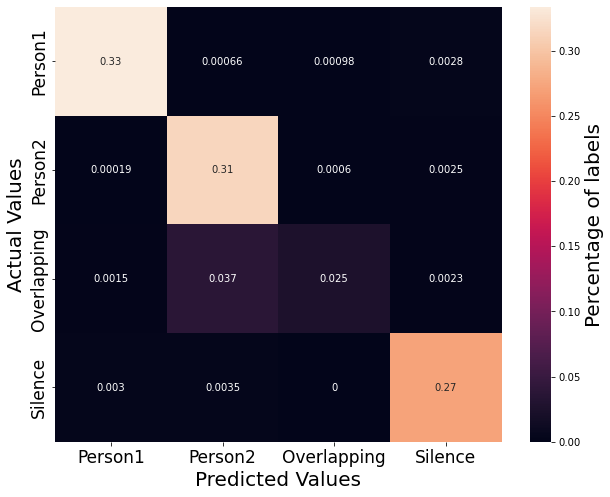

In [25]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
cm = confusion_matrix(real, predb,normalize='all')
cm_df = pd.DataFrame(cm,
                     index = ['Person1','Person2','Overlapping','Silence'], 
                     columns = ['Person1','Person2','Overlapping','Silence'])
#Plotting the confusion matrix
plt.figure(figsize=(10,8))
ax=sns.heatmap(cm_df, annot=True)
ax.collections[0].colorbar.set_label('Percentage of labels',fontsize=20)
plt.ylabel('Actual Values',fontsize=20)
plt.xlabel('Predicted Values',fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.savefig('Confmatrixlstmallnosp',bbox='tight_layout',dpi=100)
plt.show()

In [26]:
from sklearn.metrics import accuracy_score #LSTM yes 3 label all features # stogiro
#print('test accuracy: ',accuracy_score(y_test, predbintest))
#print('train accuracy: ',accuracy_score(y_val, predbinval))
print(y_test)
print(pred)
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, val_acc = model.evaluate(X_val, y_val, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('train',train_acc)
print('val',val_acc)
print('test',test_acc)

[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]
[[9.1356136e-02 2.7809086e-01 4.2284928e-02 5.8826804e-01]
 [6.3259020e-02 2.9695842e-01 4.2119704e-02 5.9766287e-01]
 [4.2258672e-02 3.1565800e-01 4.4255789e-02 5.9782755e-01]
 ...
 [9.8482668e-01 4.2259181e-03 9.4833266e-04 9.9989623e-03]
 [9.8482668e-01 4.2259181e-03 9.4833266e-04 9.9989623e-03]
 [9.8482668e-01 4.2259181e-03 9.4833266e-04 9.9989623e-03]]
train 0.9488561153411865
test 0.9452755451202393


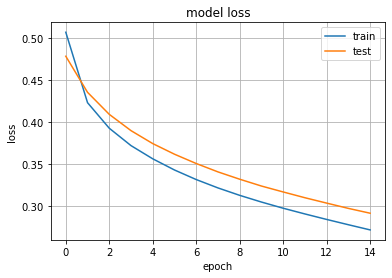

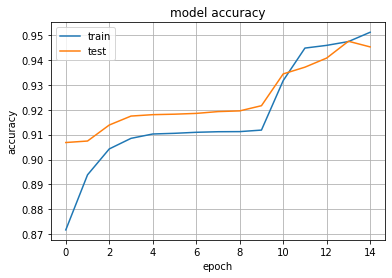

In [28]:
%matplotlib inline 
#stogiro
from matplotlib import pyplot
from matplotlib import pyplot as plt
def acc_loss(history):
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    pyplot.legend()
    pyplot.grid()
    plt.savefig('acc',bbox='tight_layout',dpi=100)
    pyplot.show()
    
    pyplot.plot(history.history['accuracy'], label='train')
    pyplot.plot(history.history['val_accuracy'], label='test')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    pyplot.legend()
    pyplot.grid()
    plt.savefig('acc',bbox='tight_layout',dpi=100)
    pyplot.show()

acc_loss(history)